In [1]:
import numpy as np
from queue import PriorityQueue
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# matrice de similarité
sim_mat = np.array([[10, 6, 0, 0, 0, 0, 0, 0, 0],
                    [6, 10, 0, 0, 0, 0, 0, 0, 0],
                    [0, 0, 10, 5, 3, 3, 1, 1, 0],
                    [0, 0, 5, 10, 1, 2, 1, 1, 0],
                    [0, 0, 3, 1, 10, 4, 1, 2, 0],
                    [0, 0, 3, 2, 4, 10, 1, 4, 0],
                    [0, 0, 1, 1, 1, 1, 10, 1, 0],
                    [0, 0, 1, 1, 2, 4, 1, 10, 0],
                    [0, 0, 0, 0, 0, 0, 0, 0, 10]])

# génération du tableau de file de priorité sans les valeurs de la diagonale
def generate_priority_queue(sim_mat):
    N = sim_mat.shape[0]
    P = []
    for i in range(N):
        P.append(PriorityQueue())
    for i in range(N):
        for j in range(N):
            if i != j:
                P[i].put((-sim_mat[i][j], j))
    return P


In [2]:
# implémentation de l'algorithme de clustering hiérarchique agglomératif
def clustering_hierarchique_agglomeratif(sim_mat):
    # Taille de la matrice de similarité
    N = sim_mat.shape[0]

    # initialisation de la liste des classes actives
    I = [1 for i in range(N)]

    # initialisation du dendrogramme comme un ndarray de taille N-1
    dendrogramme = np.zeros((N - 1, 3))

    # initialisation du tableau de file de priorité
    P = generate_priority_queue(sim_mat)
    temp_queue = PriorityQueue()
    
    # pour chaque itération k ∈ {1, . . . , N − 1} faire
    for k in range(N - 1):
        # a = argmax P[i].MAX.sim ; avec i ∈ {1, . . . , N} et I[i] = 1 ;
        a = 0
        max_sim = 1
        for i in range(N):  # on cherche la classe i la plus proche de la classe a
            if I[i] == 1 and P[i].queue[0][0] < max_sim:  # si la classe i est active et si la classe i est plus proche de la classe a que la classe a ne l'est d'elle-même
                max_sim = P[i].queue[0][0]
                a = i

        # b = P[a].MAX.index ;
        b = P[a].queue[0][1]
        
        dendrogramme[k][0] = a
        dendrogramme[k][1] = b
        dendrogramme[k][2] = 6+P[a].queue[0][0]

        # I[b] = 0 ;
        I[b] = 0

        # supprimer S[a][b] de P[a] ;
        P[a].get()

        for i in range(N):

            if I[i] == 1 and i != a:
                # supprimer S[i][a] de P[i] ;
                for j in range(P[i].qsize()):
                    if P[i].queue[0][1] != a and P[i].queue[0][1] != b:
                        temp_queue.put(P[i].queue[0])
                    P[i].get()
                # remettre les valeurs dans la file de priorité
                for j in range(temp_queue.qsize()):
                    P[i].put(temp_queue.queue[0])
                    temp_queue.get()

                # supprimer S[a][i] de P[a] ;
                for j in range(P[a].qsize()):
                    if P[a].queue[0][1] != i:
                        temp_queue.put(P[a].queue[0])
                    P[a].get()
                for j in range(temp_queue.qsize()):
                    P[a].put(temp_queue.queue[0])
                    temp_queue.get()

                # S[i][a] ← max{S[i][a], S[i][b]} ; # Méthode du lien unique
                sia = max(sim_mat[i][a], sim_mat[i][b])

                # S[a][i] ← max{S[i][a], S[i][b]} ;
                sai = max(sim_mat[i][a], sim_mat[i][b])

                # insérer (avec tri) S[i][a] dans P[i] et S[a][i] dans P[a] ;
                P[i].put((-sia, a))
                P[a].put((-sai, i))

    return dendrogramme

In [3]:
# test de l'algorithme de clustering hiérarchique agglomératif
dendrogramme = clustering_hierarchique_agglomeratif(sim_mat)
print(dendrogramme)

[[0. 1. 0.]
 [2. 3. 1.]
 [4. 5. 2.]
 [4. 7. 2.]
 [2. 4. 3.]
 [2. 6. 5.]
 [0. 2. 6.]
 [0. 8. 6.]]


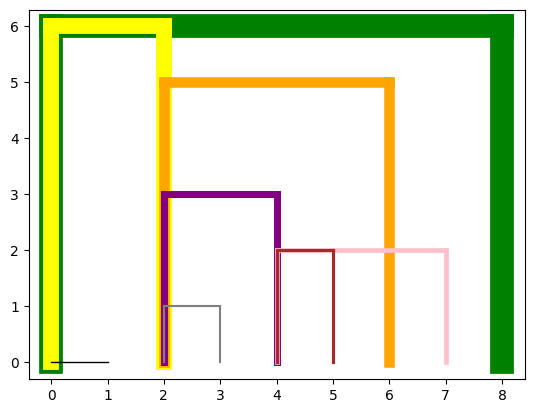

In [4]:
#AFFICHAGE DU DENDROGRAMME
def affichage_dendrogramme(dendrogramme):
    couleurs = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'pink', 'brown', 'gray', 'black']
    # reverse the order of colors so that colors are in the same order as distance values
    couleurs.reverse()
    N = dendrogramme.shape[0]
    for i in range(N - 1, -1, -1):
        #la taille de trait est proportionnelle à la similarité
        plt.plot([dendrogramme[i][0], dendrogramme[i][0]], [0, dendrogramme[i][2]], color=couleurs[i], linewidth=1.5**i)
        plt.plot([dendrogramme[i][1], dendrogramme[i][1]], [0, dendrogramme[i][2]], color=couleurs[i], linewidth=1.5**i)
        plt.plot([dendrogramme[i][0], dendrogramme[i][1]], [dendrogramme[i][2], dendrogramme[i][2]], color=couleurs[i], linewidth=1.5**i)
    plt.show()

affichage_dendrogramme(dendrogramme)

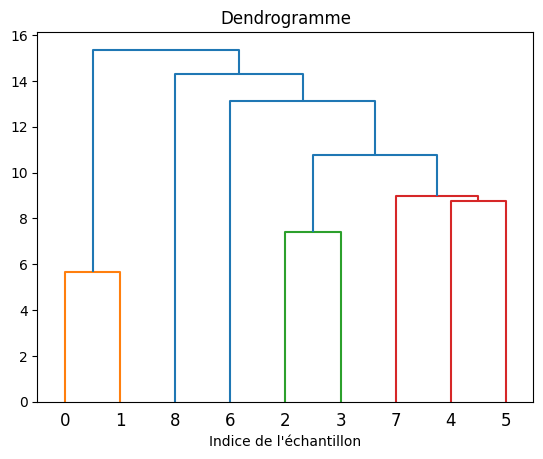

In [5]:
# maintenanat on va utiliser la fonction de scipy pour comparer les résultats
linkage_matrix = linkage(sim_mat, 'single') # Elle est composé de N-1 lignes et 4 colonnes (i, j, d, n) avec i et j les indices des clusters fusionnés, d la distance entre les clusters et n le nombre d'éléments dans le cluster
dendrogram(linkage_matrix, orientation='top')
plt.title('Dendrogramme')
plt.xlabel('Indice de l\'échantillon')
plt.show()